In [1]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
random.seed(134)

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32

## Load Data

In [2]:
train_data=pd.read_csv('snli_train.tsv', sep='\t')
val_data=pd.read_csv('snli_val.tsv', sep='\t')

In [3]:
def token(string):
    return string.lower().split()

def label(string):
    if string=='entailment':
        return 2
    elif string=='neutral':
        return 1
    else:
        return 0

In [4]:
train_data['sentence1']=train_data['sentence1'].apply(token)
train_data['sentence2']=train_data['sentence2'].apply(token)
train_data['label']=train_data['label'].apply(label)

In [5]:
val_data['sentence1']=val_data['sentence1'].apply(token)
val_data['sentence2']=val_data['sentence2'].apply(token)
val_data['label']=val_data['label'].apply(label)

In [6]:
all_words=[]
max_len1=0
max_len2=0
for i in train_data['sentence1']:
    for j in i:
        all_words.append(j)
    max_len1=max(max_len1,len(i))
for i in train_data['sentence2']:
    for j in i:
        all_words.append(j)
    max_len2=max(max_len2,len(i))

In [7]:
max_len1,max_len2

(82, 41)

In [8]:
id2char = list(set(all_words))
char2id = dict(zip(id2char, range(2,2+len(id2char))))
id2char = ['<pad>', '<unk>'] + id2char
char2id['<pad>'] = PAD_IDX
char2id['<unk>'] = UNK_IDX

In [9]:
train=[tuple(x) for x in train_data.values]
val=[tuple(x) for x in val_data.values]

In [10]:
MAX_WORD_LENGTH1=82
MAX_WORD_LENGTH2=41

In [105]:
ft_home = 'E:/Glove/fasttext/'
words_to_load = 999995

import numpy as np

with open(ft_home + 'wiki-news-300d-1M.vec',encoding='utf-8') as f:
    loaded_embeddings_ft = np.zeros((words_to_load, 300))
    words_ft = {}
    idx2words_ft = {}
    ordered_words_ft = []
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft[i, :] = np.asarray(s[1:])
        words_ft[s[0]] = i
        idx2words_ft[i] = s[0]
        ordered_words_ft.append(s[0])

In [107]:
len(words_ft)

999995

In [111]:
np.random.seed(0)
embedding_dim=300
input_embedding_matrix = np.zeros((len(id2char), embedding_dim))
for i,word in enumerate(id2char):
    if word in words_ft:
        input_embedding_matrix[i] = loaded_embeddings_ft[words_ft[word]]
    else:
        if word=='<pad>':
            new_embedding = np.array(np.zeros(embedding_dim))
        else:
            new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        idx2words_ft[len(words_ft)] = word
        words_ft[word] =len(words_ft)
        loaded_embeddings_ft=np.append(loaded_embeddings_ft,np.expand_dims(new_embedding,0),axis=0)
        input_embedding_matrix[i] = new_embedding

In [113]:
len(words_ft)

1002070

In [112]:
len(id2char),input_embedding_matrix.shape

(21025, (21025, 300))

In [11]:
# np.save('input_embedding_matrix.npy',input_embedding_matrix)
input_embedding_matrix=np.load('input_embedding_matrix.npy')

import pickle
with open('id2char.pickle', 'rb') as handle:
    id2char=pickle.load(handle)
with open('char2id.pickle', 'rb') as handle:
    char2id=pickle.load(handle)

In [12]:
class VocabDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_tuple, char2id):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.data_list1,self.data_list2, self.target_list = zip(*data_tuple)
        assert (len(self.data_list1) == len(self.target_list))
        self.char2id = char2id

    def __len__(self):
        return len(self.data_list1)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        char_idx1 = [self.char2id[c] if c in self.char2id.keys() else UNK_IDX  for c in self.data_list1[key][:MAX_WORD_LENGTH1]]
        char_idx2 = [self.char2id[c] if c in self.char2id.keys() else UNK_IDX  for c in self.data_list2[key][:MAX_WORD_LENGTH2]]
        label = self.target_list[key]
        return [char_idx1,char_idx2, len(char_idx1),len(char_idx2), label]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list1 = []
    data_list2 = []
    label_list = []
    length_list1 = []
    length_list2 = []
    for datum in batch:
        label_list.append(datum[4])
        length_list1.append(datum[2])
        length_list2.append(datum[3])
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_WORD_LENGTH1-datum[2])),
                                mode="constant", constant_values=0)
        data_list1.append(padded_vec1)
        padded_vec2 = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_WORD_LENGTH1-datum[3])),
                                mode="constant", constant_values=0)
        data_list2.append(padded_vec2)
    ind_dec_order = np.argsort(length_list1)[::-1]
    
    data_list1 = np.array(data_list1)[ind_dec_order]
    data_list2 = np.array(data_list2)[ind_dec_order]
    length_list1 = np.array(length_list1)[ind_dec_order]
    length_list2 = np.array(length_list2)[ind_dec_order]
    label_list = np.array(label_list)[ind_dec_order]
    return [torch.from_numpy(np.array(data_list1)),torch.from_numpy(np.array(data_list2)), torch.LongTensor(length_list1),torch.LongTensor(length_list2), torch.LongTensor(label_list)]

In [13]:
train_dataset = VocabDataset(train, char2id)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True,num_workers=10)

val_dataset = VocabDataset(val, char2id)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True,num_workers=10)

# test_dataset = VocabDataset(test_data, char2id)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=vocab_collate_func,
#                                            shuffle=False)

## CNN

In [14]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_classes, vocab_size,dropout=0,mod='concat'):

        super(CNN, self).__init__()

        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.weight.data.copy_(torch.from_numpy(input_embedding_matrix))
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)

        self.linear1 = nn.Linear(hidden_size*2,hidden_size*2)
        self.linear1c = nn.Linear(hidden_size,hidden_size*2)
        self.linear2 = nn.Linear(hidden_size*2, num_classes)
        self.dropout=nn.Dropout(p=dropout)
        self.relu=nn.ReLU()
        self.method=mod
    def forward(self, x1,x2): # lengths1,lengths2
        batch_size, seq_len1 = x1.size()
        _, seq_len2 = x2.size()
        embed1 = self.embedding(x1)
#         print(embed1.size())
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
#         print(hidden1.size())
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))
        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))
        hidden1 = torch.sum(hidden1, dim=1)
        embed2 = self.embedding(x2)
        hidden2 = self.conv1(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len2, hidden2.size(-1))
        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len2, hidden2.size(-1))
        hidden2 = torch.sum(hidden2, dim=1)
#         print(hidden1.size(),hidden2.size())

        if self.method=='concat':
            concat= torch.cat([hidden1, hidden2], 1)
            logits = self.relu(self.linear1(concat))
        elif self.method=='add':
            concat=hidden1+hidden2
            logits = self.relu(self.linear1c(concat))
        elif self.method=='sub':
            concat=hidden1-hidden2
            logits = self.relu(self.linear1c(concat))
        #         print(concat.size())
#         logits = self.relu(self.linear1(concat))
        logits==self.dropout(logits)
        logits = self.linear2(logits)
        return logits
    
#         concat= torch.cat([hidden1, hidden2], 1)
# #         print(concat.size())
#         logits = self.relu(self.linear1(concat))
#         logits==self.dropout(logits)
#         logits = self.linear2(logits)
#         return logits

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    losses=0
    for data1,data2, length1,length2, labels in loader:
        data1_batch,data2_batch, lengths1_batch,lengths2_batch, label_batch = data1,data2, length1,length2, labels 
        outputs = F.softmax(model(data1_batch.to(device).long(),data2_batch.to(device).long()), dim=1)
        loss = criterion(outputs, labels.to(device))
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.to(device).view_as(predicted)).sum().item()
        losses+=loss.item()
    return (100 * correct / total),losses/len(loader)


model = CNN(emb_size=300, hidden_size=200, num_classes=3, vocab_size=len(id2char)).to(device)

learning_rate = 3e-4
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

or_tr_ac=[]
or_va_ac=[]
or_tr_lo=[]
or_va_lo=[]

for epoch in range(num_epochs):
    for i, (data1,data2, length1,length2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device).long(), data2.to(device).long())
        loss = criterion(outputs, labels.to(device))
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i % 1000 == 0:
            # validate
            val_acc,val_loss = test_model(val_loader, model)
            train_acc,train_loss = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}，Validation Acc: {},Train Loss: {}，Validation Loss: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc,val_acc,train_loss,val_loss))
    or_tr_ac.append(train_acc)
    or_va_ac.append(val_acc)
    or_tr_lo.append(train_loss)
    or_va_lo.append(val_loss)

Epoch: [1/5], Step: [1/3125], Train Acc: 33.2，Validation Acc: 33.8,Train Loss: 1.197477553138733，Validation Loss: 1.1927797384560108
Epoch: [1/5], Step: [1001/3125], Train Acc: 64.151，Validation Acc: 63.8,Train Loss: 0.942289843673706，Validation Loss: 0.9545933809131384
Epoch: [1/5], Step: [2001/3125], Train Acc: 67.999，Validation Acc: 65.5,Train Loss: 0.912230235748291，Validation Loss: 0.9282675143331289
Epoch: [1/5], Step: [3001/3125], Train Acc: 68.322，Validation Acc: 63.1,Train Loss: 0.9033592533493042，Validation Loss: 0.9291591737419367
Epoch: [2/5], Step: [1/3125], Train Acc: 69.659，Validation Acc: 64.6,Train Loss: 0.8958455959129333，Validation Loss: 0.9204023033380508
Epoch: [2/5], Step: [1001/3125], Train Acc: 71.004，Validation Acc: 64.9,Train Loss: 0.8787730499839783，Validation Loss: 0.9175795651972294
Epoch: [2/5], Step: [2001/3125], Train Acc: 72.953，Validation Acc: 66.3,Train Loss: 0.866886870136261，Validation Loss: 0.9066797159612179
Epoch: [2/5], Step: [3001/3125], Train 

In [22]:
model = CNN(emb_size=300, hidden_size=200, num_classes=3, vocab_size=len(id2char),dropout=0.15).to(device)

learning_rate = 3e-4
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

dr1_tr_ac=[]
dr1_va_ac=[]
dr1_tr_lo=[]
dr1_va_lo=[]

for epoch in range(num_epochs):
    for i, (data1,data2, length1,length2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device).long(), data2.to(device).long())
        loss = criterion(outputs, labels.to(device))
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i % 1000 == 0:
            # validate
            val_acc,val_loss = test_model(val_loader, model)
            train_acc,train_loss = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}，Validation Acc: {},Train Loss: {:.4f}，Validation Loss: {:.4f}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc,val_acc,train_loss,val_loss))
    dr1_tr_ac.append(train_acc)
    dr1_va_ac.append(val_acc)
    dr1_tr_lo.append(train_loss)
    dr1_va_lo.append(val_loss)

Epoch: [1/5], Step: [1/3125], Train Acc: 33.165，Validation Acc: 33.1,Train Loss: 1.1634，Validation Loss: 1.1602
Epoch: [1/5], Step: [401/3125], Train Acc: 59.744，Validation Acc: 57.2,Train Loss: 0.9954，Validation Loss: 0.9979
Epoch: [1/5], Step: [801/3125], Train Acc: 62.382，Validation Acc: 60.1,Train Loss: 0.9562，Validation Loss: 0.9658
Epoch: [1/5], Step: [1201/3125], Train Acc: 65.172，Validation Acc: 63.2,Train Loss: 0.9337，Validation Loss: 0.9433
Epoch: [1/5], Step: [1601/3125], Train Acc: 66.835，Validation Acc: 64.0,Train Loss: 0.9211，Validation Loss: 0.9365
Epoch: [1/5], Step: [2001/3125], Train Acc: 67.917，Validation Acc: 64.5,Train Loss: 0.9125，Validation Loss: 0.9298
Epoch: [1/5], Step: [2401/3125], Train Acc: 68.766，Validation Acc: 66.0,Train Loss: 0.9150，Validation Loss: 0.9338
Epoch: [1/5], Step: [2801/3125], Train Acc: 69.018，Validation Acc: 65.4,Train Loss: 0.9073，Validation Loss: 0.9312
Epoch: [2/5], Step: [1/3125], Train Acc: 69.22，Validation Acc: 64.2,Train Loss: 0.906

In [28]:
model = CNN(emb_size=300, hidden_size=200, num_classes=3, vocab_size=len(id2char),dropout=0.3).to(device)

learning_rate = 3e-4
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

dr2_tr_ac=[]
dr2_va_ac=[]
dr2_tr_lo=[]
dr2_va_lo=[]

for epoch in range(num_epochs):
    for i, (data1,data2, length1,length2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device).long(), data2.to(device).long())
        loss = criterion(outputs, labels.to(device))
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i % 1000 == 0:
            # validate
            val_acc,val_loss = test_model(val_loader, model)
            train_acc,train_loss = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}，Validation Acc: {},Train Loss: {:.4f}，Validation Loss: {:.4f}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc,val_acc,train_loss,val_loss))
    dr2_tr_ac.append(train_acc)
    dr2_va_ac.append(val_acc)
    dr2_tr_lo.append(train_loss)
    dr2_va_lo.append(val_loss)

Epoch: [1/5], Step: [1/3125], Train Acc: 33.165，Validation Acc: 33.1,Train Loss: 1.1920，Validation Loss: 1.1932
Epoch: [1/5], Step: [1001/3125], Train Acc: 62.457，Validation Acc: 62.2,Train Loss: 0.9464，Validation Loss: 0.9534
Epoch: [1/5], Step: [2001/3125], Train Acc: 67.338，Validation Acc: 65.2,Train Loss: 0.9100，Validation Loss: 0.9217
Epoch: [1/5], Step: [3001/3125], Train Acc: 69.822，Validation Acc: 66.6,Train Loss: 0.8994，Validation Loss: 0.9244
Epoch: [2/5], Step: [1/3125], Train Acc: 69.813，Validation Acc: 65.8,Train Loss: 0.9033，Validation Loss: 0.9277
Epoch: [2/5], Step: [1001/3125], Train Acc: 71.939，Validation Acc: 67.1,Train Loss: 0.8773，Validation Loss: 0.9129
Epoch: [2/5], Step: [2001/3125], Train Acc: 73.44，Validation Acc: 65.7,Train Loss: 0.8706，Validation Loss: 0.9174
Epoch: [2/5], Step: [3001/3125], Train Acc: 75.105，Validation Acc: 67.1,Train Loss: 0.8520，Validation Loss: 0.9037
Epoch: [3/5], Step: [1/3125], Train Acc: 74.884，Validation Acc: 66.5,Train Loss: 0.8588

In [33]:
model = CNN(emb_size=300, hidden_size=400, num_classes=3, vocab_size=len(id2char),dropout=0).to(device)

learning_rate = 3e-4
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

r4_tr_ac=[]
r4_va_ac=[]
r4_tr_lo=[]
r4_va_lo=[]

for epoch in range(num_epochs):
    for i, (data1,data2, length1,length2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device).long(), data2.to(device).long())
        loss = criterion(outputs, labels.to(device))
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i % 1000 == 0:
            # validate
            val_acc,val_loss = test_model(val_loader, model)
            train_acc,train_loss = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}，Validation Acc: {},Train Loss: {:.4f}，Validation Loss: {:.4f}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc,val_acc,train_loss,val_loss))
    r4_tr_ac.append(train_acc)
    r4_va_ac.append(val_acc)
    r4_tr_lo.append(train_loss)
    r4_va_lo.append(val_loss)

Epoch: [1/5], Step: [1/3125], Train Acc: 33.165，Validation Acc: 33.1,Train Loss: 1.1959，Validation Loss: 1.2006
Epoch: [1/5], Step: [1001/3125], Train Acc: 64.762，Validation Acc: 65.4,Train Loss: 0.9437，Validation Loss: 0.9514
Epoch: [1/5], Step: [2001/3125], Train Acc: 65.405，Validation Acc: 62.0,Train Loss: 0.9351，Validation Loss: 0.9522
Epoch: [1/5], Step: [3001/3125], Train Acc: 70.463，Validation Acc: 64.3,Train Loss: 0.9007，Validation Loss: 0.9263
Epoch: [2/5], Step: [1/3125], Train Acc: 70.317，Validation Acc: 65.7,Train Loss: 0.8976，Validation Loss: 0.9277
Epoch: [2/5], Step: [1001/3125], Train Acc: 72.784，Validation Acc: 67.1,Train Loss: 0.8701，Validation Loss: 0.9046
Epoch: [2/5], Step: [2001/3125], Train Acc: 74.709，Validation Acc: 66.0,Train Loss: 0.8572，Validation Loss: 0.9087
Epoch: [2/5], Step: [3001/3125], Train Acc: 75.972，Validation Acc: 66.7,Train Loss: 0.8330，Validation Loss: 0.8904
Epoch: [3/5], Step: [1/3125], Train Acc: 76.596，Validation Acc: 67.2,Train Loss: 0.834

In [35]:
model = CNN(emb_size=300, hidden_size=600, num_classes=3, vocab_size=len(id2char),dropout=0).to(device)

learning_rate = 3e-4
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

r6_tr_ac=[]
r6_va_ac=[]
r6_tr_lo=[]
r6_va_lo=[]

for epoch in range(num_epochs):
    for i, (data1,data2, length1,length2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device).long(), data2.to(device).long())
        loss = criterion(outputs, labels.to(device))
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i % 1000 == 0:
            # validate
            val_acc,val_loss = test_model(val_loader, model)
            train_acc,train_loss = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}，Validation Acc: {},Train Loss: {:.4f}，Validation Loss: {:.4f}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc,val_acc,train_loss,val_loss))
    r6_tr_ac.append(train_acc)
    r6_va_ac.append(val_acc)
    r6_tr_lo.append(train_loss)
    r6_va_lo.append(val_loss)

Epoch: [1/5], Step: [1/3125], Train Acc: 33.165，Validation Acc: 33.1,Train Loss: 1.2198，Validation Loss: 1.2223
Epoch: [1/5], Step: [1001/3125], Train Acc: 65.048，Validation Acc: 63.8,Train Loss: 0.9372，Validation Loss: 0.9491
Epoch: [1/5], Step: [2001/3125], Train Acc: 68.276，Validation Acc: 65.4,Train Loss: 0.9148，Validation Loss: 0.9301
Epoch: [1/5], Step: [3001/3125], Train Acc: 70.633，Validation Acc: 65.9,Train Loss: 0.9028，Validation Loss: 0.9252
Epoch: [2/5], Step: [1/3125], Train Acc: 71.345，Validation Acc: 66.2,Train Loss: 0.8821，Validation Loss: 0.9112
Epoch: [2/5], Step: [1001/3125], Train Acc: 73.746，Validation Acc: 67.5,Train Loss: 0.8569，Validation Loss: 0.8954
Epoch: [2/5], Step: [2001/3125], Train Acc: 75.421，Validation Acc: 69.3,Train Loss: 0.8543，Validation Loss: 0.8963
Epoch: [2/5], Step: [3001/3125], Train Acc: 77.074，Validation Acc: 67.9,Train Loss: 0.8428，Validation Loss: 0.8949
Epoch: [3/5], Step: [1/3125], Train Acc: 76.434，Validation Acc: 66.7,Train Loss: 0.861

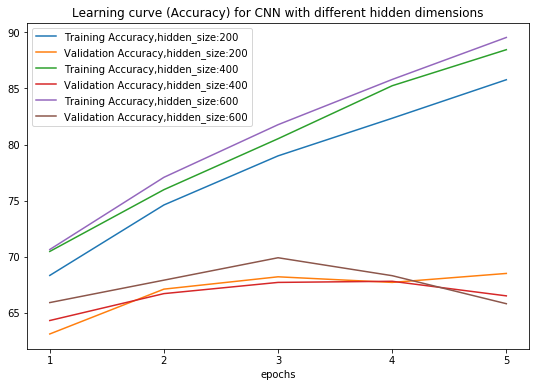

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))
plt.plot(or_tr_ac,label='Training Accuracy,hidden_size:200')
plt.plot(or_va_ac,label='Validation Accuracy,hidden_size:200')
plt.plot(r4_tr_ac ,label='Training Accuracy,hidden_size:400')
plt.plot(r4_va_ac,label='Validation Accuracy,hidden_size:400')
plt.plot(r6_tr_ac,label='Training Accuracy,hidden_size:600')
plt.plot(r6_va_ac,label='Validation Accuracy,hidden_size:600')
plt.legend()
plt.xticks(range(5),['1','2','3','4','5'])
plt.xlabel('epochs')
plt.ylabel='Accuracy'
# plt.xlabel('epochs')
# plt.ylabel('validation accuracy')
plt.title('Learning curve (Accuracy) for CNN with different hidden dimensions')
plt.show()

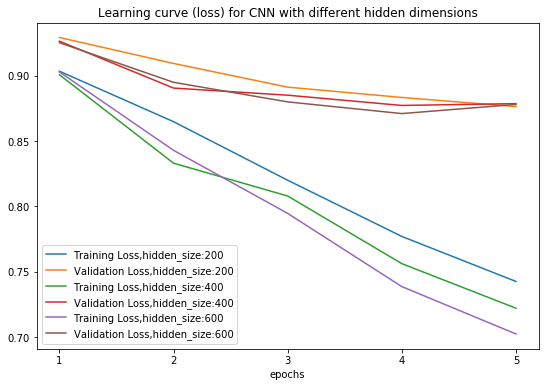

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))
plt.plot(or_tr_lo,label='Training Loss,hidden_size:200')
plt.plot(or_va_lo,label='Validation Loss,hidden_size:200')
plt.plot(r4_tr_lo ,label='Training Loss,hidden_size:400')
plt.plot(r4_va_lo,label='Validation Loss,hidden_size:400')
plt.plot(r6_tr_lo,label='Training Loss,hidden_size:600')
plt.plot(r6_va_lo,label='Validation Loss,hidden_size:600')
plt.legend()
plt.xticks(range(5),['1','2','3','4','5'])
plt.xlabel('epochs')
plt.ylabel='Loss'
# plt.xlabel('epochs')
# plt.ylabel('validation accuracy')
plt.title('Learning curve (loss) for CNN with different hidden dimensions')
plt.show()

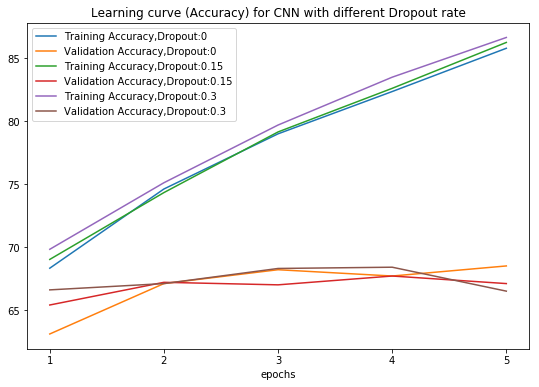

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))
plt.plot(or_tr_ac,label='Training Accuracy,Dropout:0')
plt.plot(or_va_ac,label='Validation Accuracy,Dropout:0')
plt.plot(dr1_tr_ac ,label='Training Accuracy,Dropout:0.15')
plt.plot(dr1_va_ac,label='Validation Accuracy,Dropout:0.15')
plt.plot(dr2_tr_ac,label='Training Accuracy,Dropout:0.3')
plt.plot(dr2_va_ac,label='Validation Accuracy,Dropout:0.3')
plt.legend()
plt.xticks(range(5),['1','2','3','4','5'])
plt.xlabel('epochs')
plt.ylabel='Accuracy'
# plt.xlabel('epochs')
# plt.ylabel('validation accuracy')
plt.title('Learning curve (Accuracy) for CNN with different Dropout rate')
plt.show()

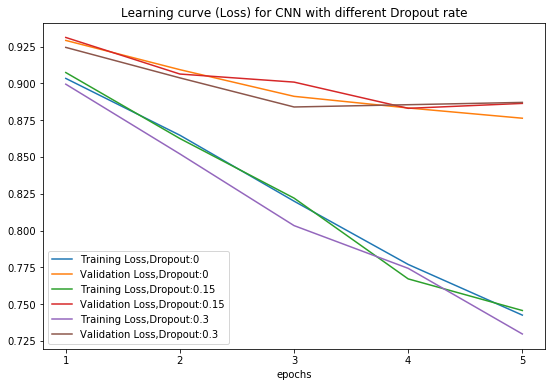

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))
plt.plot(or_tr_lo,label='Training Loss,Dropout:0')
plt.plot(or_va_lo,label='Validation Loss,Dropout:0')
plt.plot(dr1_tr_lo,label='Training Loss,Dropout:0.15')
plt.plot(dr1_va_lo,label='Validation Loss,Dropout:0.15')
plt.plot(dr2_tr_lo],label='Training Loss,Dropout:0.3')
plt.plot(dr2_va_lo,label='Validation Loss,Dropout:0.3')
plt.legend()
plt.xticks(range(5),['1','2','3','4','5'])
plt.xlabel('epochs')
plt.ylabel='Accuracy'
# plt.xlabel('epochs')
# plt.ylabel('validation accuracy')
plt.title('Learning curve (Loss) for CNN with different Dropout rate')
plt.show()

In [32]:
test_data=pd.read_csv('mnli_val.tsv', sep='\t')
for gen in set(test_data.genre):

    test=test_data[test_data.genre==gen].reset_index()

    test['sentence1']=test['sentence1'].apply(token)
    test['sentence2']=test['sentence2'].apply(token)
    test['label']=test['label'].apply(label)
    test=test[['sentence1','sentence2','label']]

    test=[tuple(x) for x in test.values]
    test_dataset = VocabDataset(test,char2id)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=vocab_collate_func,
                                               shuffle=False)
    test_acc = test_model(test_loader, model)
    print(gen,test_acc)

fiction (44.62311557788945, 1.058090429753065)
government (44.68503937007874, 1.0460979212075472)
telephone (47.16417910447761, 1.034971870481968)
slate (42.01596806387226, 1.0710842795670033)
travel (45.31568228105906, 1.0448148019852177)


## RNN

In [15]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size,dropout=0,mod='concat'):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(RNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.weight.data.copy_(torch.from_numpy(input_embedding_matrix))
        self.rnn = nn.GRU(emb_size, hidden_size, num_layers, dropout=dropout,batch_first=True,bidirectional=True)
#         self.rnn2 = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True,bidirectional=True)
        self.linear1 = nn.Linear(hidden_size*4, hidden_size*2)
        self.linear1c = nn.Linear(hidden_size*2, hidden_size*2)
        self.linear2 = nn.Linear(hidden_size*2, num_classes)
        self.dropout=nn.Dropout(p=dropout)
        self.method=mod
        self.relu=nn.ReLU()

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size)
        return hidden.cuda()

    def forward(self,x1,x2, lengths1,lengths2):
        # reset hidden state

        batch_size, seq_len = x1.size()

        self.hidden1 = self.init_hidden(batch_size)
        self.hidden2 = self.init_hidden(batch_size)
        # get embedding of characters
        embed1 = self.embedding(x1)
        # pack padded sequence
#         print(lengths1)
        embed1 = nn.utils.rnn.pack_padded_sequence(embed1, lengths1, batch_first=True)
        # fprop though RNN
        rnn_out1, self.hidden1 = self.rnn(embed1, self.hidden1)
        # undo packing
        rnn_out1, hidden1 = torch.nn.utils.rnn.pad_packed_sequence(rnn_out1, batch_first=True)
        hidden1 = torch.sum(hidden1, dim=0)
#         print(lengths2)
        embed2 = self.embedding(x2)
        # pack padded sequence
        _, idx_sort = torch.sort(lengths2, dim=0, descending=True)
        _, idx_unsort = torch.sort(idx_sort, dim=0)
        data2 = embed2.index_select(0, idx_sort)
        len2= lengths2.index_select(0, idx_sort)
        data2 = nn.utils.rnn.pack_padded_sequence(data2, len2, batch_first=True)
        rnn_out2, self.hidden2 = self.rnn(data2, self.hidden2)
        rnn_out2, hidden2 = nn.utils.rnn.pad_packed_sequence(rnn_out2, batch_first=True)
#         print(hidden.size())
        hidden2 = torch.sum(hidden2, dim=0)
        hidden2=hidden2.index_select(0, idx_unsort)
        if self.method=='concat':
            concat=torch.cat([hidden1, hidden2], 1)
            logits = self.relu(self.linear1(concat))
        elif self.method=='add':
            concat=hidden1+hidden2
            logits = self.relu(self.linear1c(concat))
        elif self.method=='sub':
            concat=hidden1-hidden2
            logits = self.relu(self.linear1c(concat))
        
        logits=self.dropout(logits)
        logits = self.linear2(logits)
        return logits


In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [17]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    losses=0
    for data1,data2, length1,length2, labels in loader:
        data1_batch,data2_batch, lengths1_batch,lengths2_batch, label_batch = data1,data2, length1,length2, labels 
        outputs = F.softmax(model(data1_batch.to(device).long(),data2_batch.to(device).long(),lengths1_batch.to(device),lengths2_batch.to(device)), dim=1)
        loss = criterion(outputs, labels.to(device))
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.to(device).view_as(predicted)).sum().item()
        losses+=loss.item()
    return (100 * correct / total),losses/len(loader)
#         predicted = outputs.max(1, keepdim=True)[1]
#         total += labels.size(0)
#         correct += predicted.eq(labels.view_as(predicted)).sum().item()
#     return (100 * correct / total)


model = RNN(emb_size=300, hidden_size=200, num_layers=2, num_classes=3, vocab_size=len(id2char)).to(device)

learning_rate = 2e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

r_tr_ac=[]
r_va_ac=[]
r_tr_lo=[]
r_va_lo=[]

for epoch in range(num_epochs):
    for i, (data1,data2, length1,length2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device).long(), data2.to(device).long(),length1.to(device),length2.to(device))
        loss = criterion(outputs, labels.to(device))
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        # validate every 100 iterations
        if i % 1000 == 0:
            # validate
            val_acc,val_loss = test_model(val_loader, model)
            train_acc,train_loss = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}，Validation Acc: {},Train Loss: {:.4f}，Validation Loss: {:.4f}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc,val_acc,train_loss,val_loss))
    r_tr_ac.append(train_acc)
    r_va_ac.append(val_acc)
    r_tr_lo.append(train_loss)
    r_va_lo.append(val_loss)


Epoch: [1/10], Step: [1/3125], Train Acc: 33.118，Validation Acc: 32.9,Train Loss: 1.1082，Validation Loss: 1.1086
Epoch: [1/10], Step: [1001/3125], Train Acc: 49.6，Validation Acc: 47.5,Train Loss: 1.0455，Validation Loss: 1.0514
Epoch: [1/10], Step: [2001/3125], Train Acc: 58.48，Validation Acc: 55.3,Train Loss: 0.9854，Validation Loss: 0.9996
Epoch: [1/10], Step: [3001/3125], Train Acc: 61.463，Validation Acc: 58.8,Train Loss: 0.9610，Validation Loss: 0.9730
Epoch: [2/10], Step: [1/3125], Train Acc: 62.061，Validation Acc: 60.2,Train Loss: 0.9553，Validation Loss: 0.9651
Epoch: [2/10], Step: [1001/3125], Train Acc: 64.321，Validation Acc: 60.8,Train Loss: 0.9424，Validation Loss: 0.9573
Epoch: [2/10], Step: [2001/3125], Train Acc: 65.373，Validation Acc: 63.6,Train Loss: 0.9273，Validation Loss: 0.9458
Epoch: [2/10], Step: [3001/3125], Train Acc: 66.302，Validation Acc: 62.9,Train Loss: 0.9254，Validation Loss: 0.9442
Epoch: [3/10], Step: [1/3125], Train Acc: 66.911，Validation Acc: 63.6,Train Loss:

In [25]:
model = RNN(emb_size=300, hidden_size=400, num_layers=2, num_classes=3, vocab_size=len(id2char),dropout=0).to(device)

learning_rate = 1e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

r_tr_ac=[]
r_va_ac=[]
r_tr_lo=[]
r_va_lo=[]

for epoch in range(num_epochs):
    for i, (data1,data2, length1,length2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device).long(), data2.to(device).long(),length1.to(device),length2.to(device))
        loss = criterion(outputs, labels.to(device))
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        # validate every 100 iterations
        if i % 1000 == 0:
            # validate
            val_acc,val_loss = test_model(val_loader, model)
            train_acc,train_loss = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}，Validation Acc: {},Train Loss: {:.4f}，Validation Loss: {:.4f}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc,val_acc,train_loss,val_loss))
    r_tr_ac.append(train_acc)
    r_va_ac.append(val_acc)
    r_tr_lo.append(train_loss)
    r_va_lo.append(val_loss)


Epoch: [1/10], Step: [1/3125], Train Acc: 33.223，Validation Acc: 31.0,Train Loss: 1.1043，Validation Loss: 1.1079
Epoch: [1/10], Step: [1001/3125], Train Acc: 52.09，Validation Acc: 48.8,Train Loss: 1.0254，Validation Loss: 1.0360
Epoch: [1/10], Step: [2001/3125], Train Acc: 59.523，Validation Acc: 58.3,Train Loss: 0.9783，Validation Loss: 0.9882
Epoch: [1/10], Step: [3001/3125], Train Acc: 62.604，Validation Acc: 59.0,Train Loss: 0.9532，Validation Loss: 0.9685
Epoch: [2/10], Step: [1/3125], Train Acc: 62.564，Validation Acc: 61.1,Train Loss: 0.9552，Validation Loss: 0.9650
Epoch: [2/10], Step: [1001/3125], Train Acc: 63.928，Validation Acc: 61.7,Train Loss: 0.9356，Validation Loss: 0.9521
Epoch: [2/10], Step: [2001/3125], Train Acc: 65.529，Validation Acc: 63.1,Train Loss: 0.9174，Validation Loss: 0.9360
Epoch: [2/10], Step: [3001/3125], Train Acc: 66.659，Validation Acc: 63.7,Train Loss: 0.9183，Validation Loss: 0.9397
Epoch: [3/10], Step: [1/3125], Train Acc: 66.611，Validation Acc: 63.5,Train Los

In [56]:
model = RNN(emb_size=300, hidden_size=400, num_layers=2, num_classes=3, vocab_size=len(id2char),dropout=0,mod='sub').to(device)

learning_rate = 1e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

rs_tr_ac=[]
rs_va_ac=[]
rs_tr_lo=[]
rs_va_lo=[]

for epoch in range(num_epochs):
    for i, (data1,data2, length1,length2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device).long(), data2.to(device).long(),length1.to(device),length2.to(device))
        loss = criterion(outputs, labels.to(device))
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        # validate every 100 iterations
        if i % 1000 == 0:
            # validate
            val_acc,val_loss = test_model(val_loader, model)
            train_acc,train_loss = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}，Validation Acc: {},Train Loss: {:.4f}，Validation Loss: {:.4f}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc,val_acc,train_loss,val_loss))
    rs_tr_ac.append(train_acc)
    rs_va_ac.append(val_acc)
    rs_tr_lo.append(train_loss)
    rs_va_lo.append(val_loss)

Epoch: [1/10], Step: [1/3125], Train Acc: 33.044，Validation Acc: 32.6,Train Loss: 1.1078，Validation Loss: 1.1034
Epoch: [1/10], Step: [1001/3125], Train Acc: 48.669，Validation Acc: 45.3,Train Loss: 1.0484，Validation Loss: 1.0594
Epoch: [1/10], Step: [2001/3125], Train Acc: 57.477，Validation Acc: 54.8,Train Loss: 0.9920，Validation Loss: 1.0109
Epoch: [1/10], Step: [3001/3125], Train Acc: 63.012，Validation Acc: 60.9,Train Loss: 0.9540，Validation Loss: 0.9727
Epoch: [2/10], Step: [1/3125], Train Acc: 62.3，Validation Acc: 59.2,Train Loss: 0.9636，Validation Loss: 0.9781
Epoch: [2/10], Step: [1001/3125], Train Acc: 65.206，Validation Acc: 62.9,Train Loss: 0.9285，Validation Loss: 0.9472
Epoch: [2/10], Step: [2001/3125], Train Acc: 67.764，Validation Acc: 64.8,Train Loss: 0.9120，Validation Loss: 0.9324
Epoch: [2/10], Step: [3001/3125], Train Acc: 69.942，Validation Acc: 65.7,Train Loss: 0.9079，Validation Loss: 0.9364
Epoch: [3/10], Step: [1/3125], Train Acc: 70.342，Validation Acc: 64.9,Train Loss

In [29]:
model = RNN(emb_size=300, hidden_size=400, num_layers=2, num_classes=3, vocab_size=len(id2char),dropout=0,mod='add').to(device)

learning_rate = 1e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

ra_tr_ac=[]
ra_va_ac=[]
ra_tr_lo=[]
ra_va_lo=[]

for epoch in range(num_epochs):
    for i, (data1,data2, length1,length2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device).long(), data2.to(device).long(),length1.to(device),length2.to(device))
        loss = criterion(outputs, labels.to(device))
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        # validate every 100 iterations
        if i % 1000 == 0:
            # validate
            val_acc,val_loss = test_model(val_loader, model)
            train_acc,train_loss = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}，Validation Acc: {},Train Loss: {:.4f}，Validation Loss: {:.4f}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc,val_acc,train_loss,val_loss))
    ra_tr_ac.append(train_acc)
    ra_va_ac.append(val_acc)
    ra_tr_lo.append(train_loss)
    ra_va_lo.append(val_loss)


Epoch: [1/10], Step: [1/3125], Train Acc: 33.866，Validation Acc: 31.5,Train Loss: 1.1054，Validation Loss: 1.1144
Epoch: [1/10], Step: [1001/3125], Train Acc: 38.54，Validation Acc: 37.9,Train Loss: 1.0903，Validation Loss: 1.0925
Epoch: [1/10], Step: [2001/3125], Train Acc: 43.722，Validation Acc: 43.3,Train Loss: 1.0712，Validation Loss: 1.0734
Epoch: [1/10], Step: [3001/3125], Train Acc: 46.829，Validation Acc: 45.0,Train Loss: 1.0621，Validation Loss: 1.0649
Epoch: [2/10], Step: [1/3125], Train Acc: 47.373，Validation Acc: 48.3,Train Loss: 1.0577，Validation Loss: 1.0581
Epoch: [2/10], Step: [1001/3125], Train Acc: 50.907，Validation Acc: 51.5,Train Loss: 1.0398，Validation Loss: 1.0429
Epoch: [2/10], Step: [2001/3125], Train Acc: 53.556，Validation Acc: 50.1,Train Loss: 1.0289，Validation Loss: 1.0387
Epoch: [2/10], Step: [3001/3125], Train Acc: 55.129，Validation Acc: 52.5,Train Loss: 1.0252，Validation Loss: 1.0362
Epoch: [3/10], Step: [1/3125], Train Acc: 55.818，Validation Acc: 51.4,Train Los

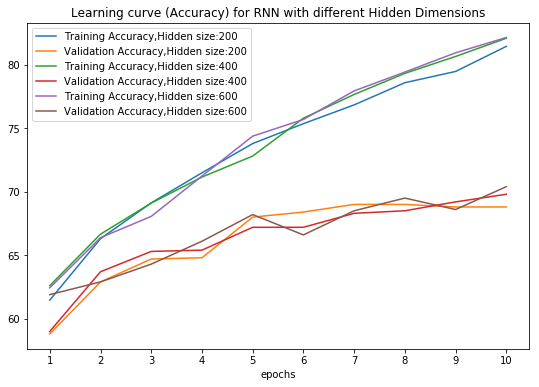

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))
plt.plot(o_tr_ac,label='Training Accuracy,Hidden size:200')
plt.plot(o_va_ac,label='Validation Accuracy,Hidden size:200')
plt.plot(r_tr_ac ,label='Training Accuracy,Hidden size:400')
plt.plot(r_va_ac,label='Validation Accuracy,Hidden size:400')
plt.plot(r6_tr_ac,label='Training Accuracy,Hidden size:600')
plt.plot(r6_va_ac,label='Validation Accuracy,Hidden size:600')
plt.legend()
plt.xticks(range(10),['1','2','3','4','5','6','7','8','9','10'])
plt.xlabel('epochs')
plt.ylabel='Accuracy'
# plt.xlabel('epochs')
# plt.ylabel('validation accuracy')
plt.title('Learning curve (Accuracy) for RNN with different Hidden Dimensions')
plt.show()

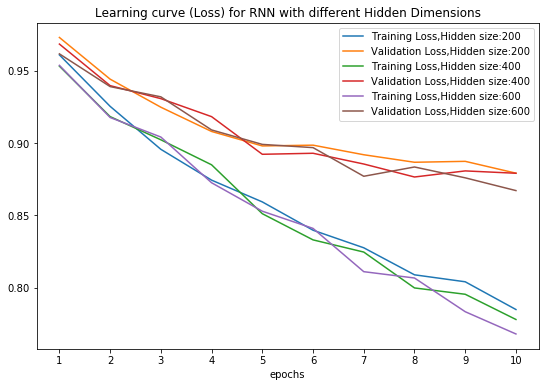

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))
plt.plot(o_tr_lo,label='Training Loss,Hidden size:200')
plt.plot(o_va_lo,label='Validation Loss,Hidden size:200')
plt.plot(r_tr_lo ,label='Training Loss,Hidden size:400')
plt.plot(r_va_lo,label='Validation Loss,Hidden size:400')
plt.plot(r6_tr_lo,label='Training Loss,Hidden size:600')
plt.plot(r6_va_lo,label='Validation Loss,Hidden size:600')
plt.legend()
plt.xticks(range(10),['1','2','3','4','5','6','7','8','9','10'])
plt.xlabel('epochs')
plt.ylabel='Accuracy'
# plt.xlabel('epochs')
# plt.ylabel('validation accuracy')
plt.title('Learning curve (Loss) for RNN with different Hidden Dimensions')
plt.show()

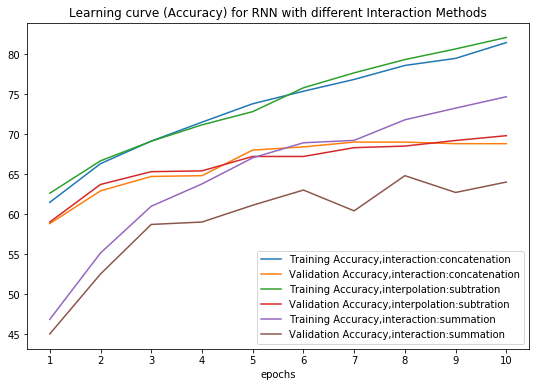

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))
plt.plot(o_tr_ac,label='Training Accuracy,interaction:concatenation')
plt.plot(o_va_ac,label='Validation Accuracy,interaction:concatenation')
plt.plot(rs_tr_ac,label='Training Accuracy,interaction:subtration')
plt.plot(rs_va_ac,label='Validation Accuracy,interaction:subtration')
plt.plot(ra_tr_ac,label='Training Accuracy,interaction:summation')
plt.plot(ra_va_ac,label='Validation Accuracy,interaction:summation')
plt.legend()
plt.xticks(range(10),['1','2','3','4','5','6','7','8','9','10'])
plt.xlabel('epochs')
# plt.ylabel='Accuracy'
# plt.xlabel('epochs')
# plt.ylabel('validation accuracy')
plt.title('Learning curve (Accuracy) for RNN with different Interaction Methods')
plt.show()

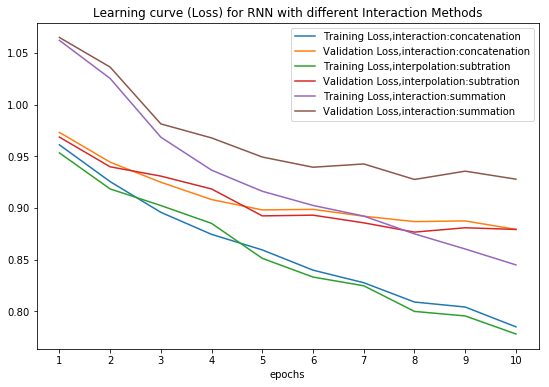

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,6))
plt.plot(o_tr_lo,label='Training Loss,interaction:concatenation')
plt.plot(o_va_lo,label='Validation Loss,interaction:concatenation')
plt.plot(rs_tr_lo,label='Training Loss,interaction:subtration')
plt.plot(rs_va_lo,label='Validation Loss,interaction:subtration')
plt.plot(ra_tr_lo,label='Training Loss,interaction:summation')
plt.plot(ra_va_lo,label='Validation Loss,interaction:summation')
plt.legend()
plt.xticks(range(10),['1','2','3','4','5','6','7','8','9','10'])
plt.xlabel('epochs')
# plt.ylabel('Accuracy')
# plt.xlabel('epochs')
# plt.ylabel('validation accuracy')
plt.title('Learning curve (Loss) for RNN with different Interaction Methods')
plt.show()

In [58]:
test_data=pd.read_csv('mnli_val.tsv', sep='\t')
for gen in set(test_data.genre):

    test=test_data[test_data.genre==gen].reset_index()

    test['sentence1']=test['sentence1'].apply(token)
    test['sentence2']=test['sentence2'].apply(token)
    test['label']=test['label'].apply(label)
    test=test[['sentence1','sentence2','label']]

    test=[tuple(x) for x in test.values]
    test_dataset = VocabDataset(test,char2id)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=vocab_collate_func,
                                               shuffle=False)
    test_acc = test_model(test_loader, model)
    print(gen,test_acc)

fiction (43.81909547738694, 1.0944183692336082)
telephone (44.17910447761194, 1.0792191941291094)
travel (43.9918533604888, 1.0763398620390123)
government (47.73622047244095, 1.0529732555150986)
slate (44.31137724550898, 1.0895737316459417)


## Correct and Incorrect Prediction

In [49]:
model.eval()
i=0

for data1,data2, length1,length2, labels in val_loader:
    data1_batch,data2_batch, lengths1_batch,lengths2_batch, label_batch = data1,data2, length1,length2, labels 
    outputs = F.softmax(model(data1_batch.to(device).long(),data2_batch.to(device).long(),lengths1_batch.to(device),lengths2_batch.to(device)), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    for j in range(len(outputs)):
        if predicted[j].eq(labels.to(device)[j].view_as(predicted[j])).sum().item()!=1:
            i+=1
            print(' '.join([id2char[i.item()] for i in data1_batch[j] if i.item()!=0]))
            print(' '.join([id2char[i.item()] for i in data2_batch[j] if i.item()!=0]))
            print('target: ', labels[j].item())
            print('predicted: ', predicted[j].item())
        if i==5:
            break
    if i==5:
        break
i=0   
for data1,data2, length1,length2, labels in val_loader:
    data1_batch,data2_batch, lengths1_batch,lengths2_batch, label_batch = data1,data2, length1,length2, labels 
    outputs = F.softmax(model(data1_batch.to(device).long(),data2_batch.to(device).long(),lengths1_batch.to(device),lengths2_batch.to(device)), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    for j in range(len(outputs)):
        if predicted[j].eq(labels.to(device)[j].view_as(predicted[j])).sum().item()==1:
            i+=1
            print(' '.join([id2char[i.item()] for i in data1_batch[j] if i.item()!=0]))
            print(' '.join([id2char[i.item()] for i in data2_batch[j] if i.item()!=0]))
            print('target: ', labels[j].item())
            print('predicted: ', predicted[j].item())
        if i==5:
            break
    if i==5:
        break
      

a male bartender dressed in all black with his sleeves rolled up to elbow height making a drink in a martini glass .
a person in black
target:  2
predicted:  0
a building that <unk> beautiful architecture stands in the sunlight as somebody on a bike passes by .
a bicyclist rides past an abandoned warehouse on a rainy day
target:  1
predicted:  0
a young girl jumps high with the help of her bungie harness device and a safety spotter .
a child jumps high , assisted by a spotter and a harness .
target:  2
predicted:  0
here is a picture of a woman and her husband in their car smiling and waving .
here is a picture of a woman and her husband '
target:  2
predicted:  1
a woman sitting in a tan chair beside of a dog while smiling at the camera .
the man is an actor at a photoshoot .
target:  0
predicted:  1
a young girl with a white vest , pink sleeves and pink knit hat with flower is looking at the flower blossoms on a tree .
the girl is dressed up for a party .
target:  1
predicted:  1
a l

In [57]:
model = RNN(emb_size=300, hidden_size=600, num_layers=2,num_classes=3, vocab_size=len(id2char),dropout=0,mod='sub').to(device)

learning_rate = 1e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

r_tr_ac=[]
r_va_ac=[]
r_tr_lo=[]
r_va_lo=[]

for epoch in range(num_epochs):
    for i, (data1,data2, length1,length2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device).long(), data2.to(device).long(),length1.to(device),length2.to(device))
        loss = criterion(outputs, labels.to(device))
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        # validate every 100 iterations
        if i % 1000 == 0:
            # validate
            val_acc,val_loss = test_model(val_loader, model)
            train_acc,train_loss = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}，Validation Acc: {},Train Loss: {:.4f}，Validation Loss: {:.4f}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc,val_acc,train_loss,val_loss))
    r_tr_ac.append(train_acc)
    r_va_ac.append(val_acc)
    r_tr_lo.append(train_loss)
    r_va_lo.append(val_loss)

#         if i > 0 and i % 100 == 0:
#             # validate
#             val_acc,_ = test_model(val_loader, model)5
#             train_acc,_ = test_model(train_loader, model)
#             print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}，Validation Acc: {}'.format(
#                        epoch+1, num_epochs, i+1, len(train_loader), train_acc,val_acc))

Epoch: [1/10], Step: [1/3125], Train Acc: 32.943，Validation Acc: 32.7,Train Loss: 1.1083，Validation Loss: 1.1046
Epoch: [1/10], Step: [1001/3125], Train Acc: 41.676，Validation Acc: 39.4,Train Loss: 1.0733，Validation Loss: 1.0792
Epoch: [1/10], Step: [2001/3125], Train Acc: 51.725，Validation Acc: 49.5,Train Loss: 1.0321，Validation Loss: 1.0404
Epoch: [1/10], Step: [3001/3125], Train Acc: 56.805，Validation Acc: 53.4,Train Loss: 0.9978，Validation Loss: 1.0109
Epoch: [2/10], Step: [1/3125], Train Acc: 57.458，Validation Acc: 54.9,Train Loss: 0.9944，Validation Loss: 1.0100
Epoch: [2/10], Step: [1001/3125], Train Acc: 60.392，Validation Acc: 57.6,Train Loss: 0.9723，Validation Loss: 0.9865
Epoch: [2/10], Step: [2001/3125], Train Acc: 62.798，Validation Acc: 61.0,Train Loss: 0.9567，Validation Loss: 0.9694
Epoch: [2/10], Step: [3001/3125], Train Acc: 64.485，Validation Acc: 62.8,Train Loss: 0.9533，Validation Loss: 0.9650
Epoch: [3/10], Step: [1/3125], Train Acc: 64.835，Validation Acc: 62.2,Train Lo

## Fine-Tuning on MultiNLI

In [ ]:
torch.save(model.state_dict(), 'checkpoint.pth')

state_dict = torch.load('checkpoint.pth')
model.load_state_dict(state_dict)

In [65]:
t_data=pd.read_csv('mnli_train.tsv', sep='\t')
test_data=pd.read_csv('mnli_val.tsv', sep='\t')
for gen in set(t_data.genre):

    train=t_data[t_data.genre==gen].reset_index()

    train['sentence1']=train['sentence1'].apply(token)
    train['sentence2']=train['sentence2'].apply(token)
    train['label']=train['label'].apply(label)
    train=train[['sentence1','sentence2','label']]

    train=[tuple(x) for x in train.values]
    train_dataset = VocabDataset(train,char2id)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=vocab_collate_func,
                                               shuffle=False)
#     test_acc = test_model(test_loader, model)
    test=test_data[test_data.genre==gen].reset_index()

    test['sentence1']=test['sentence1'].apply(token)
    test['sentence2']=test['sentence2'].apply(token)
    test['label']=test['label'].apply(label)
    test=test[['sentence1','sentence2','label']]

    test=[tuple(x) for x in test.values]
    test_dataset = VocabDataset(test,char2id)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=vocab_collate_func,
                                               shuffle=False)
    print(gen)
    state_dict = torch.load('checkpoint.pth')
    model.load_state_dict(state_dict)
    learning_rate= 1e-4
    num_epochs = 5 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)

    ra_tr_ac=[]
    ra_va_ac=[]
    ra_tr_lo=[]
    ra_va_lo=[]

    for epoch in range(num_epochs):
        for i, (data1,data2, length1,length2, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data1.to(device).long(), data2.to(device).long(),length1.to(device),length2.to(device))
            loss = criterion(outputs, labels.to(device))
            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            # validate every 100 iterations
            if i % 1000 == 0:
                # validate
                val_acc,val_loss = test_model(test_loader, model)
                train_acc,train_loss = test_model(train_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}，Validation Acc: {},Train Loss: {:.4f}，Validation Loss: {:.4f}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), train_acc,val_acc,train_loss,val_loss))
        ra_tr_ac.append(train_acc)
        ra_va_ac.append(val_acc)
        ra_tr_lo.append(train_loss)
        ra_va_lo.append(val_loss)
    print(test_model(test_loader, model))


government
Epoch: [1/5], Step: [1/122], Train Acc: 46.92248261653361，Validation Acc: 48.12992125984252,Train Loss: 1.0448，Validation Loss: 1.0361
Epoch: [2/5], Step: [1/122], Train Acc: 54.88024723152202，Validation Acc: 51.27952755905512,Train Loss: 1.0029，Validation Loss: 1.0208
Epoch: [3/5], Step: [1/122], Train Acc: 60.700489312387326，Validation Acc: 53.93700787401575,Train Loss: 0.9784，Validation Loss: 1.0112
Epoch: [4/5], Step: [1/122], Train Acc: 63.43033736801442，Validation Acc: 55.21653543307087,Train Loss: 0.9567，Validation Loss: 1.0054
Epoch: [5/5], Step: [1/122], Train Acc: 67.37058975019315，Validation Acc: 54.52755905511811,Train Loss: 0.9320，Validation Loss: 1.0065
(54.724409448818896, 0.9988048356026411)
travel
Epoch: [1/5], Step: [1/125], Train Acc: 45.82183186951067，Validation Acc: 43.27902240325866,Train Loss: 1.0511，Validation Loss: 1.0623
Epoch: [2/5], Step: [1/125], Train Acc: 54.40401505646173，Validation Acc: 48.676171079429736,Train Loss: 1.0137，Validation Loss: 1